# 走神司机检测
本项目的数据来源是kaggle走神司机项目的[数据集](https://www.kaggle.com/c/state-farm-distracted-driver-detection/data)。该数据集包含了10种类别的司机驾驶中的行为。为了简化处理，本项目已经将所有的数据下载并解压到跟本文件同目录，之后的所有操作建立在如下目录结构基础上：<br>
├── distracted_driver_detection.ipynb<br>
├── driver_imgs_list.csv<br>
└── imgs<br>
 &emsp;&emsp;├──test [79726 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp;└──train [22423 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c0 [2489 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c1 [2267 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c2 [2317 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c3 [2346 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c4 [2326 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c5 [2312 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c6 [2325 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c7 [2002 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c8 [1911 images]<br>
 &emsp;&emsp; &emsp;&emsp;└── c9 [2129 images]<br>
├── cache [.h5 files] <br>
└── subm [.csv file]<br>

## 数据探索

In [1]:
import numpy as np
import os
import glob
import cv2
import pickle
import datetime
import pandas as pd
import time
import shutil
import warnings
import keras
warnings.filterwarnings("ignore")
np.random.seed(2018)
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Dropout, Activation, Flatten,GlobalAveragePooling2D
from keras.optimizers import SGD,Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate
from PIL import *
import random
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from keras.applications.resnet50 import preprocess_input as res50_preprocess_input
%matplotlib inline

Using TensorFlow backend.
c:\users\mrxue\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# 读取csv数据
sns.set(color_codes=True)#导入seaborn包设定颜色
driver_image_lists = pd.read_csv('driver_imgs_list.csv')
driver_image_lists.tail()

,subject,classname,img
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg
22423,p081,c9,img_9684.jpg


In [21]:
# 探索不同类别数据的分布
classname_transfer = driver_image_lists['classname'].str[1:].astype('float32')

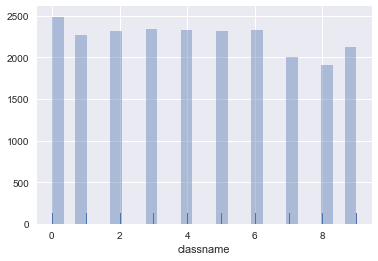

In [22]:
ax=sns.distplot(classname_transfer, kde=False, rug=True)

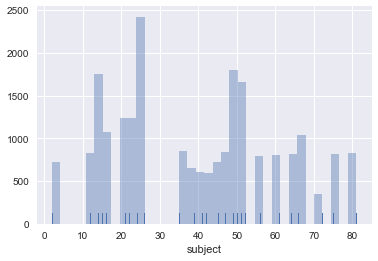

In [3]:
# 探索不同类别数据的分布
subject_transfer = driver_image_lists['subject'].str[1:].astype('float32')
ax2 = sns.distplot(subject_transfer,kde=False,rug=True)

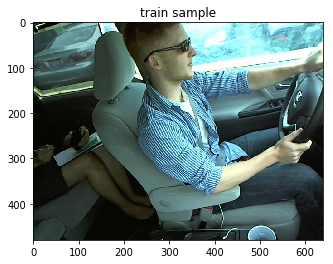

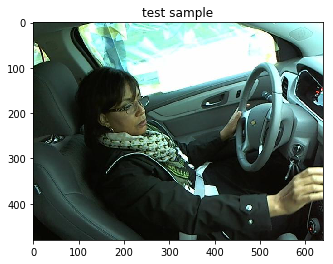

In [2]:
# 随机在训练集和测试集中分别选取一张图片进行展示
def show_sample(): 
    train_image_path = os.path.join('imgs','train','c0','*.jpg')
    test_image_path = os.path.join('imgs','test','*.jpg')
    train_files = glob.glob(train_image_path)
    test_files = glob.glob(test_image_path)
    train_file_index = 0
    test_file_index = 0
    for fl in train_files:
        if train_file_index == 0:
            img = cv2.imread(fl)
            RGB_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            plt.imshow(RGB_img)
            plt.title('train sample')
            plt.show()
            break
    for fl in test_files:
        if test_file_index == 0:
            img = cv2.imread(fl)
            RGB_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            plt.imshow(RGB_img)
            plt.title('test sample')
            plt.show()
            break
show_sample()

## 数据获取 

In [2]:
# 利用cv2读取，输出图像RGB信息，读取单个图像的信息维度为224x224x3，类型为uint8
def get_img(path,size=(224,224)):
    img = image.load_img(path, target_size=size)
    img = image.img_to_array(img)
    img = img.astype(dtype=np.uint8)
    return img

In [3]:
# 获取司机视角的信息，返回图像和司机的一一映射，以及司机为key，图像和分类为value的映射
def get_driver_data():
    dr = dict()
    clss = dict()
    path = os.path.join('driver_imgs_list.csv')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
        if arr[0] not in clss.keys():
            clss[arr[0]] = [(arr[1], arr[2])]
        else:
            clss[arr[0]].append((arr[1], arr[2]))
    f.close()
    return dr, clss

In [4]:
# 载入所有原始训练集数据，返回各图像RGB信息，分类信息，图像唯一标识，图像司机id构成的数组，以及去重后的所有司机id数组
def load_train_data(size=(224,224)):
    X_train = []
    X_train_id = []
    y_train = []
    driver_id = []
    start_time = time.time()
    driver_data, dr_class = get_driver_data()

    for j in range(10):
        path = os.path.join('imgs', 'train', 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_img(fl,size)
            X_train.append(img)
            X_train_id.append(flbase)
            y_train.append(j)
            driver_id.append(driver_data[flbase])

    unique_drivers = sorted(list(set(driver_id)))
    return X_train, y_train, X_train_id, driver_id, unique_drivers

In [5]:
def split_list(l, wanted_parts=1):
    length = len(l)
    return [l[i*length // wanted_parts: (i+1)*length // wanted_parts] for i in range(wanted_parts)]

In [6]:
# 获取测试集数据
def load_test_data(part,size=(224,224)):
    path = os.path.join('imgs', 'test', '*.jpg')
    files = sorted(glob.glob(path))
    ch = split_list(files,10)
    X_test = []
    X_test_id = []
    for fl in ch[part]:
        flbase = os.path.basename(fl)
        img = get_img(fl,size)
        X_test.append(img)
        X_test_id.append(flbase)

    return X_test, X_test_id

In [7]:
# 载入训练数据并进行预处理
def read_train_data(size=(224,224)):
    start_time = time.time()
    train_data, train_target, train_id, driver_id, unique_drivers = load_train_data(size)
    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)
    train_target = np_utils.to_categorical(train_target,10)
    
    return train_data, train_target, train_id, driver_id, unique_drivers

In [8]:
# 载入测试数据并进行预处理
def read_test_data(part,size=(224,224)):
    start_time = time.time()
    test_data, test_id = load_test_data(part,size)
    test_data = np.array(test_data, dtype=np.uint8)
    return test_data, test_id

## 数据缓存

In [9]:
# 缓存数据
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')

In [10]:
#　恢复数据
def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

## 构建模型
利用预训练模型构建本项目模型

In [11]:
def my_model(MODEL,learning_rate=1e-5):
    input_tensor = Input(shape=(224, 224, 3))
    base_model = MODEL(input_tensor=input_tensor,weights='imagenet',include_top=False)
    x = base_model.output
    # 全局平均池化
    x = GlobalAveragePooling2D()(x)
    if base_model.name != 'resnet50':
        x = Dense(4096,activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(4096,activation='relu')(x)
        x = Dropout(0.5)(x)
    predictions = Dense(10,activation='softmax')(x)
    model = Model(inputs=base_model.input,outputs=predictions)
    adam = Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])
    modelname = base_model.name    
    return model,modelname

In [12]:
# 在一种训练集上做训练
def train_model(model,modelname,foldnum,X_train,y_train,X_valid,y_valid,epochs,batchsize):
    start_time = time.time()
    weights_path = os.path.join('cache','weights_'+modelname+'_'+str(foldnum)+'.h5')
    if not os.path.isfile(weights_path):
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, verbose=0),
            ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True, verbose=0),
        ]
        model.fit(X_train, y_train, batch_size=batchsize, nb_epoch=epochs,
                  shuffle=True, verbose=1, validation_data=(X_valid, y_valid),
                  callbacks=callbacks)
    if os.path.isfile(weights_path):
        model.load_weights(weights_path)
    predictions_valid = model.predict(X_valid, batch_size=batchsize, verbose=0)
    score = round(log_loss(y_valid, predictions_valid),4)
    end_time = time.time()
    train_time = round(end_time - start_time,2)
    return score

In [13]:
# 从原始数据集中拷贝指定司机的图像数据，构建训练集和验证集的特征和标签数据
def copy_selected_drivers(train_data, train_target, driver_id, driver_list):
    # 找出driver_list所有司机在driver_id中图片的索引
    index_list = []
    train_data = np.array(train_data,dtype='uint8')
    train_target = np.array(train_target,dtype='uint8')
    for i in range(len(driver_id)):
        if driver_id[i] in driver_list:
            index_list.append(i)
    data = train_data[index_list]
    target = train_target[index_list]
    return data, target

In [14]:
# 由于内存限制，需要每进行一次分割，就要进行训练，而不是等所有分割完成之后再做训练，这里利用内置的预处理函数做预处理
def kfold_train_data(epochs,batchsize,MODEL,preprocess_func,learning_rate,nfolds=10):
    logloss_scores = []
    random_state = 51
    train_data, train_target, train_id, driver_id, unique_drivers = read_train_data()
    kf = KFold(len(unique_drivers),n_folds=nfolds,shuffle=True,random_state=random_state)
    num_fold = 0
    for train_drivers,valid_drivers in kf:
        num_fold += 1
        unique_train_drivers = [unique_drivers[i] for i in train_drivers]
        X_train,y_train = copy_selected_drivers(train_data,train_target,driver_id,unique_train_drivers)
        unique_valid_drivers = [unique_drivers[i] for i in valid_drivers]
        X_valid,y_valid = copy_selected_drivers(train_data,train_target,driver_id,unique_valid_drivers)
        X_train = X_train.astype('float16')
        X_valid = X_valid.astype('float16')
        model,modelname = my_model(MODEL,learning_rate)
        X_train = preprocess_func(X_train)
        X_valid = preprocess_func(X_valid)
        
        score = train_model(model,modelname,num_fold,X_train,y_train,X_valid,y_valid,epochs,batchsize)
        logloss_scores.append(score)
        
    return logloss_scores

## 模型预测
利用训练好的模型在测试集上做预测，对k个分类器取平均结果作为最终的预测结果

In [15]:
# 返回K组预测平均值
def predict_mean(data,nfolds):
    first_fold = np.array(data[0])
    for i in range(1,nfolds):
        first_fold += np.array(data[i])
    first_fold /= nfolds
    return first_fold.tolist()

In [16]:
def append_chunk(main,part):
    for p in part:
        main.append(p)
    return main

In [17]:
# 应用内置的preprocess_input对测试数据预处理后做预测
def predict_test_data(MODEL,preprocess_func,nfolds=10):
    model,modelname = my_model(MODEL)
    num_fold = 0
    prediction_list = []
    testid_list = []
    testid_cache_path = os.path.join('cache','testid_list.h5')
    for i in range(nfolds):
        num_fold = num_fold+1
        weights_path = os.path.join('cache','weights_'+modelname+'_'+str(num_fold)+'.h5')
        if not os.path.isfile(weights_path):
            print(weights_path+' File not exists')
            return false
        start = time.time()
        model.load_weights(weights_path)
        test_prediction_cache_path = os.path.join('cache','test_prediction_'+modelname+'_'+str(num_fold)+'.h5')
        if not os.path.isfile(test_prediction_cache_path):
            prediction = []
            # 测试数据分批读入、预处理、预测
            for part in range(10):
                test_data_chunk, test_id_chunk = read_test_data(part,target_size)
                # 测试数据预处理方式与训练集一致
                test_data_chunk = test_data_chunk.astype('float16')
                test_data_chunk = preprocess_func(test_data_chunk)
                prediction_part = model.predict(test_data_chunk)
                prediction = append_chunk(prediction,prediction_part)
                if i == 0:
                    testid_list = append_chunk(testid_list,test_id_chunk)
                    cache_data(testid_list,testid_cache_path)
            cache_data(prediction,test_prediction_cache_path)
            prediction_list.append(prediction)
        elif not os.path.isfile(testid_cache_path):
            for part in range(10):
                test_data_chunk, test_id_chunk = read_test_data(part)
                if i == 0:
                    testid_list = append_chunk(testid_list,test_id_chunk)
                    cache_data(testid_list,testid_cache_path)
            prediction = restore_data(test_prediction_cache_path)
            prediction_list.append(prediction)
        else:
            prediction = restore_data(test_prediction_cache_path)
            prediction_list.append(prediction)
            if i == 0:
                testid_list = restore_data(testid_cache_path)
        end_time = time.time()
        predict_time = round(end_time - start,2)
    return prediction_list,testid_list

## 生成提交数据
对预测结果进一步处理，并写入到csv文件中，以便提交至kaggle

In [18]:
def create_submission(predictions,testid_list,filename,submit_file_path='subm'):
    # 为了避免极端值，进行数据裁剪
    predictions = predictions.clip(min=1e-15,max=(1-1e-15))
    df = pd.DataFrame(np.array(predictions),columns=['c'+str(i) for i in range(10)])
    df.insert(0,'img',testid_list)
    path = os.path.join(submit_file_path,filename)
    df.to_csv(path,index=None)
    print('Create submit file finished')

In [19]:
if not os.path.isdir('cache'):
    os.mkdir('cache')
if not os.path.isdir('subm'):
    os.mkdir('subm')

## 绘制学习曲线
分别利用vgg16、vgg19、resnet50绘制学习曲线，由于k折过程模型的学习过程是一样的， 因此这里每种模型都只绘制一个fold的学习曲线来说明学习过程。

In [65]:
def show_learning_curve(history1,history2,modelname,learning_rate1,learning_rate2):
    f = plt.figure(figsize=(15,5))
    ax = f.add_subplot(121)
    ax.plot(history1.history['loss'])
    ax.plot(history1.history['val_loss'])
    title1 = modelname+'  loss with learning rate: '+str(learning_rate1)
    ax.set_title(title1)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax2 = f.add_subplot(122)
    ax2.plot(history2.history['loss'])
    ax2.plot(history2.history['val_loss'])
    title2 = modelname+'  loss with learning rate: '+str(learning_rate2)
    ax2.set_title(title2)
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')

In [26]:
def kfold_train_data_for_curve(epochs,batchsize,MODEL,preprocess_func,learning_rate,nfolds=10):
    logloss_scores = []
    random_state = 51
    train_data, train_target, train_id, driver_id, unique_drivers = read_train_data()
    kf = KFold(len(unique_drivers),n_folds=nfolds,shuffle=True,random_state=random_state)
    num_fold = 0
    for train_drivers,valid_drivers in kf:
        num_fold += 1
        unique_train_drivers = [unique_drivers[i] for i in train_drivers]
        X_train,y_train = copy_selected_drivers(train_data,train_target,driver_id,unique_train_drivers)
        unique_valid_drivers = [unique_drivers[i] for i in valid_drivers]
        X_valid,y_valid = copy_selected_drivers(train_data,train_target,driver_id,unique_valid_drivers)
        X_train = X_train.astype('float16')
        X_valid = X_valid.astype('float16')
        model,modelname = my_model(MODEL,learning_rate)
        X_train = preprocess_func(X_train)
        X_valid = preprocess_func(X_valid)
        history = model.fit(X_train, y_train, batch_size=batchsize, nb_epoch=epochs,
                  shuffle=True, verbose=0, validation_data=(X_valid, y_valid))
        return history

In [25]:
vgg16_history1 = kfold_train_data_for_curve(10,16,VGG16,vgg16_preprocess_input,1e-5)

In [27]:
vgg16_history2 = kfold_train_data_for_curve(10,16,VGG16,vgg16_preprocess_input,1e-6)

In [28]:
vgg19_history1 = kfold_train_data_for_curve(10,16,VGG19,vgg19_preprocess_input,1e-5)

In [29]:
vgg19_history2 = kfold_train_data_for_curve(10,16,VGG19,vgg19_preprocess_input,1e-6)

In [30]:
resnet50_history1 = kfold_train_data_for_curve(10,16,ResNet50,res50_preprocess_input,1e-5)

In [31]:
resnet50_history2 = kfold_train_data_for_curve(10,16,ResNet50,res50_preprocess_input,1e-6)

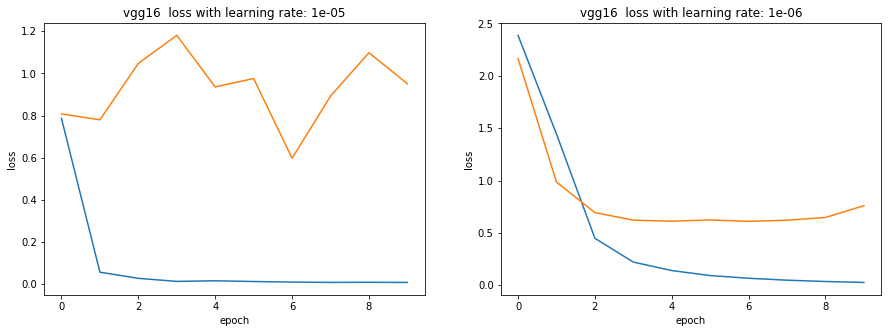

In [66]:
show_learning_curve(vgg16_history1,vgg16_history2,'vgg16',1e-5,1e-6)

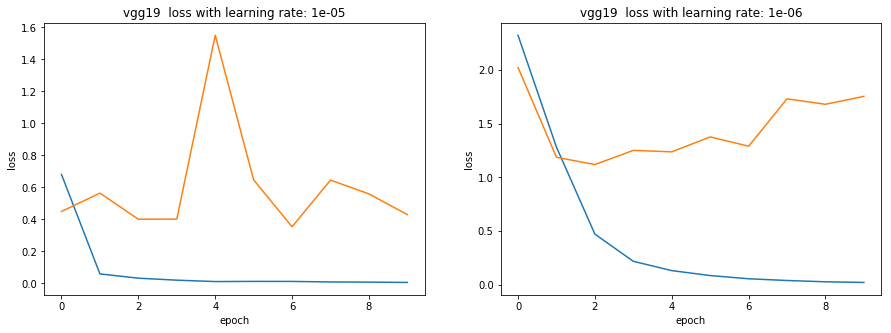

In [67]:
show_learning_curve(vgg19_history1,vgg19_history2,'vgg19',1e-5,1e-6)

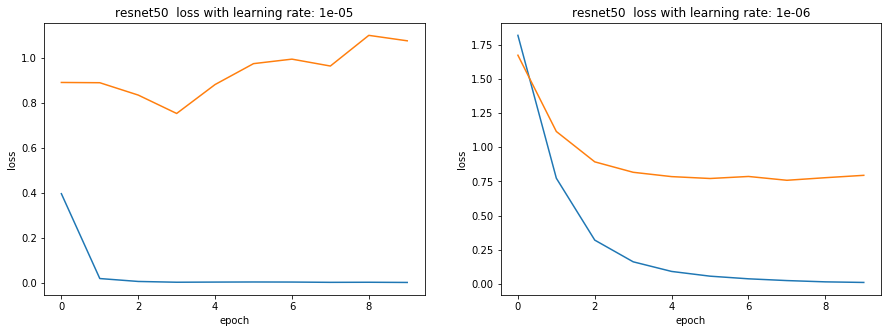

In [68]:
show_learning_curve(resnet50_history1,resnet50_history2,'resnet50',1e-5,1e-6)

## 模型训练和预测
分别利用vgg16、vgg19、resnet50进行10折训练和预测，输出训练过程及预测结果

In [20]:
logloss_scores_vgg16 = kfold_train_data(10,16,VGG16,vgg16_preprocess_input,1e-5)

In [22]:
logloss_scores_vgg19 = kfold_train_data(10,16,VGG19,vgg19_preprocess_input,1e-5)

In [24]:
logloss_scores_res50 = kfold_train_data(10,16,ResNet50,res50_preprocess_input,1e-5)

In [25]:
prediction_list_vgg16,testid_list_vgg16 = predict_test_data(VGG16,vgg16_preprocess_input)

In [26]:
prediction_list_vgg19,testid_list_vgg19 = predict_test_data(VGG19,vgg19_preprocess_input)

In [27]:
prediction_list_res50,testid_list_res50 = predict_test_data(ResNet50,res50_preprocess_input)

## 结果处理及模型融合

In [28]:
index_list = ['fold'+str(i+1)+'-val-loss' for i in range(10)]
dataframe = pd.DataFrame({'vgg16-logloss':logloss_scores_vgg16,
                          'vgg19-logloss':logloss_scores_vgg19,
                          'res50-logloss':logloss_scores_res50},
                         index=index_list)
dataframe

,res50-logloss,vgg16-logloss,vgg19-logloss
fold1-val-loss,0.5234,0.4336,0.6124
fold2-val-loss,0.4667,0.3494,0.4797
fold3-val-loss,0.3435,0.3033,0.3473
fold4-val-loss,0.3169,0.3953,0.5224
fold5-val-loss,0.2333,0.2269,0.2292
fold6-val-loss,0.2384,0.3407,0.3150
fold7-val-loss,0.6515,0.5532,0.7193
fold8-val-loss,0.6347,0.8077,0.7732
fold9-val-loss,0.2648,0.3049,0.2354
fold10-val-loss,0.4552,0.3760,0.7363


In [31]:
result_with10_vgg16 = predict_mean(prediction_list_vgg16,10)
result_with10_vgg16 = np.array(result_with10_vgg16)

In [32]:
result_with10_vgg19 = predict_mean(prediction_list_vgg19,10)
result_with10_vgg19 = np.array(result_with10_vgg19)

In [33]:
result_with10_res50 = predict_mean(prediction_list_res50,10)
result_with10_res50 = np.array(result_with10_res50)

In [39]:
create_submission(result_with10_vgg16,testid_list_vgg16,'submission_10_vgg16.csv')

Create submit file finished


In [40]:
create_submission(result_with10_vgg19,testid_list_vgg19,'submission_10_vgg19.csv')

Create submit file finished


In [41]:
create_submission(result_with10_res50,testid_list_res50,'submission_10_res50.csv')

Create submit file finished


In [43]:
result_with10_3avg = (result_with10_vgg16+result_with10_vgg19+result_with10_res50)/3
create_submission(result_with10_3avg,testid_list_vgg16,'submission_10_3avg.csv')

Create submit file finished


In [45]:
result_with10_2avg_16_and19 = (result_with10_vgg16+result_with10_vgg19)/2
create_submission(result_with10_2avg_16_and19,testid_list_vgg16,'submission_10_2avg_16_and19.csv')

Create submit file finished


In [46]:
result_with10_2avg_16_and50 = (result_with10_vgg16+result_with10_res50)/2
create_submission(result_with10_2avg_16_and50,testid_list_vgg16,'submission_10_2avg_16_and50.csv')

Create submit file finished
